### Pytorch Transformer on Collective Variables

In [18]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.distributions as dist
import torch.optim as optim
from torch import nn, einsum

from torch.utils.data import DataLoader
import sys
import os

#Custom
import utilities
torch.max_split_size_mb = 4096
device = torch.device("cuda:0")

from mixture_of_experts import MoE

#### Import Dataset, Calculate Means and Covariances of Bonds and Angles

In [179]:
GLOBAL_HIDDEN_SIZE = 512
GLOBAL_NUM_BINS = 600
GLOBAL_DROPOUT = 0.00
GLOBAL_NUM_ATTN_HEADS = 4
GLOBAL_QKV_DEPTH = 128 #GLOBAL_HIDDEN_SIZE/GLOBAL_NUM_ATTN_HEADS
GLOBAL_BATCH_SIZE = 512
#decoder_specific
GLOBAL_DECODER_EXPERTS = 4
GLOBAL_DECODER_LAYERS = 12

In [180]:
MMCD_path = "./"
sys.path.append(MMCD_path)
from mmcd import MMCDataset

name = 'decaalanine'
data_path = os.path.join(MMCD_path, "data")

dataset_train = MMCDataset(root = data_path,
                           molecule_name = name,
                           train = True,
                           coordinate_type = 'internal',
                           lazy_load = False)

dataset_test = MMCDataset(root = './data',
                           molecule_name = name,
                           train = False,
                           coordinate_type = 'internal')

whole_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = 160000, #256 is the default batch size
                          shuffle = True)

train_loader = DataLoader(dataset_train,
                          num_workers = 1,
                          batch_size = GLOBAL_BATCH_SIZE, #256 is the default batch size
                          shuffle = True)

for batch_idx, (whole_data, _) in enumerate(whole_loader):
    #Flatten the data into a tensor of size (batch_size, 300) tensor before putting it into the GPU
    whole_data = utilities.flatten_data(whole_data).to(device) #for deccalanine
    #tr_cov, tr_means, bonds_angles_dist = utilities.return_ba_mean_covar(data, dec=True)

#del tr_cov, tr_means, whole_loader

In [181]:
unimodal_indx = torch.tensor([1, 4, 5, 7, 8, 10, 11, 15, 16, 19, 21, 24, 25, 27, 28, 30, 31, 35, 36, 39, 41, 44, 45, 47, 48, 50, 51, 55, 56, 59, 61, 64, 65, 67, 68, 70, 71, 75, 76, 79, 81, 84, 85, 87, 88, 90, 91, 94, 97, 98]).to(device)
pi_indx = torch.tensor([0, 2, 13, 18, 20, 22, 33, 38, 40, 42, 53, 58, 60, 73, 78, 80, 82, 93, 95]).to(device)
multimodal_indx = torch.tensor([3, 6, 9, 12, 14, 17, 23, 26, 29, 32, 34, 37, 43, 46, 49, 52, 54, 57, 62, 63, 66, 69, 72, 74, 77, 83, 86, 89, 92, 96]).to(device)

In [182]:
bonds_angles = whole_data[:, :-99] #99+99+3
dihedrals = whole_data[:, 201:] #99

#gather special dihedrals
unimodal_dihedrals = torch.index_select(dihedrals, 1, unimodal_indx)
pi_dihedrals = torch.index_select(dihedrals, 1, pi_indx)
multi_dihedrals = torch.index_select(dihedrals, 1, multimodal_indx)

#convert to pi_dihedrals to unimodal step
trans_pi_dihedrals = torch.where(pi_dihedrals < 0, pi_dihedrals + 2*torch.pi, pi_dihedrals)
trans_pi_dihedrals = trans_pi_dihedrals - torch.pi

In [183]:
#reserved for futher usage
"""
#convert to unimodal step
m = torch.where(pi_dihedral < 0, pi_dihedral + 2*torch.pi, pi_dihedral)
m = m - torch.pi

#convert to divided step
m = torch.where(m < 0, m + torch.pi, m)
m = torch.where(m < 2, m - torch.pi, m)
"""

'\n#convert to unimodal step\nm = torch.where(pi_dihedral < 0, pi_dihedral + 2*torch.pi, pi_dihedral)\nm = m - torch.pi\n\n#convert to divided step\nm = torch.where(m < 0, m + torch.pi, m)\nm = torch.where(m < 2, m - torch.pi, m)\n'

In [184]:
unimodal_data = torch.cat([bonds_angles, unimodal_dihedrals, trans_pi_dihedrals], dim=1)
unimodal_data = unimodal_data.permute(1, 0)
np_unimodal_data = unimodal_data.cpu().numpy()

covmat = np.cov(np_unimodal_data)
means = np.mean(np_unimodal_data, axis = 1)

tr_cov = torch.tensor(covmat).double().to(device)
tr_means = torch.tensor(means).double().to(device)

unimodal_dist = dist.MultivariateNormal(loc = tr_means, covariance_matrix = tr_cov)

#### Model

In [185]:
def custom_bucketize(input_, num_bins, lower_bound = -torch.pi, upper_bound = torch.pi, right=True):
    bounds = torch.linspace(start=lower_bound, end=upper_bound, steps=num_bins).to(device)
    return torch.bucketize(input_, bounds).to(device)

def un_bucketize_dict(num_bins, lower_bound = -torch.pi, upper_bound = torch.pi):
    unbucket_dict = dict()
    data_range = upper_bound - lower_bound
    delta = data_range/num_bins
    lower_value = lower_bound + delta/2
    for iter in range(0, num_bins+1, 1):
        unbucket_dict[iter] = lower_value
        lower_value = lower_value + delta
    return unbucket_dict

def un_bucketize(input_, num_bins, device=torch.device('cuda:0'), 
                lower_bound = -torch.pi, upper_bound = torch.pi):
    unbucket_dict = un_bucketize_dict(num_bins, lower_bound=-torch.pi, upper_bound=torch.pi)
    np_input = input_.cpu().numpy()
    return torch.tensor( np.vectorize(unbucket_dict.get)(np_input) ).to(device)

def return_unimodal_multimodal(flattened_data):
    flattened_data = flattened_data.to(device)
    bonds_angles = flattened_data[:, :-99].to(device)
    dihedrals = flattened_data[:, 201:].to(device)
    
    unimodal_dihedrals = torch.index_select(dihedrals, 1, unimodal_indx).to(device)
    pi_dihedrals = torch.index_select(dihedrals, 1, pi_indx).to(device)
    multi_dihedrals = torch.index_select(dihedrals, 1, multimodal_indx).to(device)
    unimodal_data = torch.cat([bonds_angles, unimodal_dihedrals, pi_dihedrals], dim=1).to(device)
    
    return unimodal_data, multi_dihedrals

def statistical_unbucketize(input_, num_bins, lower_bound=-torch.pi, upper_bound=torch.pi):
    """Unbucketize in a sampling operation"""
    data_linspace = torch.linspace(start=lower_bound, end=upper_bound, steps=GLOBAL_NUM_BINS+1)

    uniform_dist_dict = dict()
    data_range = 2*torch.pi
    delta = data_range/GLOBAL_NUM_BINS
    
    np_input = input_.cpu().numpy()
    
    for iter in range(0, GLOBAL_NUM_BINS, 1):
        lower_range = data_linspace[iter]
        upper_range = data_linspace[iter+1]
        uniform_dist_dict[iter] = torch.distributions.Uniform(lower_range, upper_range)
    
    sample_item = lambda item: item.sample()
    #resol = np.vectorize(sample_item)(result) 

    dist_array =  np.vectorize(uniform_dist_dict.get)(np_input)
    return np.vectorize(sample_item)(dist_array)

#### Model and Mixture of Experts

In [186]:
class UnitNormClipper(object):

    def __init__(self, frequency=5):
        self.frequency = frequency

    def __call__(self, module):
        # filter the variables to get the ones you want
        if hasattr(module, 'weight'):
            w = module.weight.data
            w.clamp(-1000, 1000)
            module.weight.data = w

clipper = UnitNormClipper
model.apply(clipper)

TransformerIC(
  (output_function): Softmax(dim=1)
  (loss_function): CrossEntropyLoss()
  (loss_function_no_sum): CrossEntropyLoss()
  (embeds): Embedding(600, 512)
  (input_dropout): Dropout(p=0.0, inplace=False)
  (output_dense): Linear(in_features=512, out_features=600, bias=True)
  (decoderlayers): ModuleList(
    (0): DecoderLayer(
      (attn): Attn(
        (q_dense): Linear(in_features=512, out_features=512, bias=False)
        (k_dense): Linear(in_features=512, out_features=512, bias=False)
        (v_dense): Linear(in_features=512, out_features=512, bias=False)
        (output_dense): Linear(in_features=512, out_features=512, bias=False)
      )
      (dropout): Dropout(p=0.0, inplace=False)
      (layernorm_attn): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (layernorm_attn2): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (layernorm_ffn): LayerNorm((512,), eps=1e-06, elementwise_affine=True)
      (MoE): MoE(
        (gate): Top2Gating()
       

In [193]:
#############################
### Unconditional Decoder ###
#############################

class DecoderLayer(nn.Module):
    """Implements a single layer of an unconditional ImageTransformer"""
    def __init__(self):
        self.hidden_size = GLOBAL_HIDDEN_SIZE

        super().__init__()
        self.attn = Attn()
        self.dropout = nn.Dropout(p=GLOBAL_DROPOUT)
        self.layernorm_attn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.layernorm_attn2 = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        self.layernorm_ffn = nn.LayerNorm([self.hidden_size], eps=1e-6, elementwise_affine=True)
        
        self.MoE = MoE(
            dim = GLOBAL_HIDDEN_SIZE,
            num_experts = GLOBAL_DECODER_EXPERTS, # increase the experts (# parameters) of your model without increasing computation
            hidden_dim = GLOBAL_HIDDEN_SIZE * 4, #size of hidden dimension in each expert, defaults to 4 * dimension
            activation = nn.LeakyReLU,      # use your preferred activation, will default to GELU
            second_policy_train = 'random', # in top_2 gating, policy for whether to use a second-place expert
            second_policy_eval = 'random',  # all (always) | none (never) | threshold (if gate value > the given threshold) | random (if gate value > threshold * random_uniform(0, 1))
            second_threshold_train = 0.2,
            second_threshold_eval = 0.2,
            capacity_factor_train = 1.25,   # experts have fixed capacity per batch. we need some extra capacity in case gating is not perfectly balanced.
            capacity_factor_eval = 2.,      # capacity_factor_* should be set to a value >=1
            loss_coef = 1e-2                # multiplier on the auxiliary expert balancing auxiliary loss
        ).to(device)

    def forward(self, X, encoder_output=None):
        #the first layer of a decoder is just normal self-attention
        y = self.attn(X, use_encoder_output=False, autoregressive_mask=True)
        X = self.layernorm_attn(self.dropout(y) + X)
        #the second layer of a decoder uses outputs from the encoder as query and key values
        """
        y = self.attn(X, encoder_output=encoder_output, 
            use_encoder_output=True, autoregressive_mask=True)
        X = self.layernorm_attn2(self.dropout(y) + X)
        """
        #but note that both attentions need masking
        y, _ = self.MoE(X)
        X = self.layernorm_ffn(self.dropout(y) + X)
        return X

############
### Attn ###
############

class Attn(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = GLOBAL_HIDDEN_SIZE
        self.num_heads = GLOBAL_NUM_ATTN_HEADS
        self.kd = GLOBAL_QKV_DEPTH*self.num_heads
        self.vd = GLOBAL_QKV_DEPTH*self.num_heads

        self.q_dense = nn.Linear(self.hidden_size, self.kd, bias=False)
        self.k_dense = nn.Linear(self.hidden_size, self.kd, bias=False)
        self.v_dense = nn.Linear(self.hidden_size, self.vd, bias=False)
        self.output_dense = nn.Linear(self.vd, self.hidden_size, bias=False)
        
        assert self.kd % self.num_heads == 0
        assert self.vd % self.num_heads == 0

    def dot_product_attention(self, q, k, v, bias=None):
        logits = torch.einsum("...kd,...qd->...qk", k, q)
        if bias is not None:
            logits += bias
        weights = F.softmax(logits, dim=-1)
        return weights @ v

    def forward(self, X, encoder_output=None, autoregressive_mask=True, use_encoder_output=False):
        if use_encoder_output == False: 
            q = self.q_dense(X)
            k = self.k_dense(X)
            v = self.v_dense(X)
        elif use_encoder_output == True: 
            v = self.v_dense(X)
            q = self.q_dense(encoder_output.clone())
            k = self.k_dense(encoder_output.clone())

        #Split to shape [batch_size, num_heads, len, depth / num_heads]
        q = q.view(q.shape[:-1] + (self.num_heads, self.kd // self.num_heads)).permute([0, 2, 1, 3])
        k = k.view(k.shape[:-1] + (self.num_heads, self.kd // self.num_heads)).permute([0, 2, 1, 3])
        v = v.view(v.shape[:-1] + (self.num_heads, self.vd // self.num_heads)).permute([0, 2, 1, 3])
        q *= (self.kd // self.num_heads) ** (-0.5) #normalized dot product or something
        
        if autoregressive_mask == True: 
            bias = -1e10*torch.triu(torch.ones(X.shape[1], X.shape[1]), 1).to(X.device)
            result = self.dot_product_attention(q, k, v, bias=bias)
        elif autoregressive_mask == False: 
            result = self.dot_product_attention(q, k, v, bias=None)

        result = result.permute([0, 2, 1, 3]).contiguous()
        result = result.view(result.shape[0:2] + (-1,))
        result = self.output_dense(result)
        return result

###########################
### Means and Covar Est ###
###########################

class Unimodal(nn.Module):
    """Estimates the distribution of the 270 other unimodal distributions"""
    def __init__(self, means, covar_mat):
        super().__init__()
        self.hidden_size = GLOBAL_HIDDEN_SIZE
        self.decoder_dims = 30
        self.unimodal_dims = 270
        self.base_means = means#.repeat(self.batch_size, 1).to(device)
        
        #lower triangular Cholesky decomposition
        self.base_lower_tril = torch.linalg.cholesky(covar_mat, upper=False)
        #self.base_lower_tril = self.base_lower_tril.repeat(self.batch_size, 1, 1).to(device)
        
        self.compressed_size = int(self.hidden_size/64) # 512 -> 8
                                            
        self.ffn_compressor = nn.Sequential(nn.Linear(self.hidden_size, int(self.hidden_size/8), bias=True),
                    nn.LeakyReLU(), nn.Linear(int(self.hidden_size/8), int(self.hidden_size/64), bias=True),
                    nn.LeakyReLU()) #2 layer feed forward (boomers call this a MLP)
        
        self.dims = int(self.compressed_size*self.decoder_dims) #needs a better name
        
        self.means_ffn = nn.Linear(self.dims, self.unimodal_dims)
        self.matrix_ffn = nn.Linear(self.dims, self.unimodal_dims**2)
        self.diag_ffn = nn.Linear(self.dims, self.unimodal_dims)
        
        self.factor = nn.Parameter( torch.tensor(-10.0) )
        self.factor_2 = nn.Parameter( torch.tensor(-10.0) )
    
    def forward(self, decoder_embeddings):
        """Reshaped decoder_embeddings has size [batch_size, decoder_dims, global_hidden_size]"""
        curr_batch_size =  decoder_embeddings.size()[0]
        
        hidden = self.ffn_compressor(decoder_embeddings) #processed by a semi_deep nn
    
        flat_hidden = hidden.view(curr_batch_size, -1)
        flat_hidden_2 = flat_hidden.clone()
        flat_hidden_3 = flat_hidden.clone()
        
        means = self.means_ffn(flat_hidden)
        means = self.base_means.repeat(curr_batch_size, 1).to(device) + \
            torch.exp(self.factor)*torch.tanh(means)
        
        diag = torch.exp( self.diag_ffn(flat_hidden_3) )
        diag_mat = torch.diag_embed(diag)
        
        matrix = self.matrix_ffn(flat_hidden_2)
        matrix = matrix.view([hidden.size()[0], self.unimodal_dims, self.unimodal_dims])
        lower_tril = torch.tril(matrix, diagonal=-1) #the diaglonal needs to be positive
        lower_tril = self.base_lower_tril.repeat(curr_batch_size, 1, 1).to(device) + \
            torch.exp(self.factor_2)*torch.tanh(lower_tril + diag_mat)
        
        #print(lower_tril[0, 269, :])
        return (means, lower_tril)
    
##########################
### Actual Transformer ###
##########################

class TransformerIC(nn.Module):
    def __init__(self, given_means, given_covar):
        super(TransformerIC, self).__init__()
        #model specific params
        self.hidden_size = GLOBAL_HIDDEN_SIZE
        self.num_bins = GLOBAL_NUM_BINS
        self.dropout = GLOBAL_DROPOUT
        self.dnlayers = GLOBAL_DECODER_LAYERS
        #data specific params
        self.batch_size = GLOBAL_BATCH_SIZE
        self.num_other_dim = 270 #99+3
        self.num_decoder_dim = 30 #99
        #functions
        self.output_function = torch.nn.Softmax(dim=1)
        self.loss_function = nn.CrossEntropyLoss()
        self.loss_function_no_sum = nn.CrossEntropyLoss(reduction="none")
        #model components
        self.embeds = nn.Embedding(self.num_bins, self.hidden_size)
        self.input_dropout = nn.Dropout(self.dropout)
        self.output_dense = nn.Linear(self.hidden_size, self.num_bins, bias=True)
        self.decoderlayers = nn.ModuleList([DecoderLayer() for _ in range(self.dnlayers)])
        self.pos_embedder_1 = torch.nn.Embedding(self.num_decoder_dim, 
            self.hidden_size) #decoder pos embedding
        #unimodal estimator
        self.unimodal_estimator = Unimodal(means = given_means, covar_mat = given_covar)
        #set the weights of the unimodal estimator to be very low. 
    
    def shift_and_pad_(self, X): 
        """For the purpose of autoregressive property. Shift inputs over by 1 and pad.
        x should be [256, 19, 8]. Pad 2nd to last dimension, 
        since 1st dimension is batch and last is embedding."""
        X = X[:, :-1, :]
        X = F.pad(X, (0, 0, 1, 0)) #kinda need to figure out how this works
        return X

    def forward(self, decoder_input=None, unimodal_input=None, sampling=False, 
                get_multivar=True, parallel_sampling=(False, 0, None)):            
        
        if parallel_sampling[0] == True:
            return self.sample(batch_size = parallel_sampling[1], device=parallel_sampling[2])
    
        #not used in training, but used by sampling
        if sampling: #sampling the 30 multimodal distributions
            curr_infer_length = decoder_input.shape[1]
            decoder_input = F.pad(decoder_input, (0, self.num_decoder_dim - curr_infer_length))  
        #apply embedding and shift and pad
        decoder_input = self.shift_and_pad_(self.embeds(decoder_input) * (self.hidden_size ** 0.5))
        #apply positional embedding
        pos_index = torch.arange(0, self.num_decoder_dim).repeat(decoder_input.size()[0], 1).to(device)
        decoder_input = decoder_input + self.pos_embedder_1(pos_index)
        #we copy this to estimate the means and covar
        decoder_input_copy = decoder_input.clone() 
        #pass through decoder layers
        for layer in self.decoderlayers:
            decoder_input = layer(decoder_input) 
        decoder_output = self.output_dense(decoder_input) 
        #decoder_output has dims [batch_size, decoder_dim, num_bins]
        reshaped_decoder_output = decoder_output.view(self.batch_size, -1)
        
        if get_multivar==True: 
            multivar_normal = self.unimodal_estimator(decoder_input_copy)
        else:
            multivar_normal = None
        
        if sampling:
            return decoder_output
        
        return decoder_output, multivar_normal

    def sample(self, batch_size, device, detach=False): #batch size is num samples
        """sampling procedure does not require gradients"""
        total_len = self.num_decoder_dim
        samples = torch.zeros((batch_size, 1)).to(device).long()
        
        if detach == True:
            samples = samples.detach()

        for curr_infer_length in range(total_len):
            outputs = self.forward(decoder_input=samples, sampling=True, get_multivar=False)
            outputs = outputs[:, curr_infer_length]
            categorical = self.output_function(outputs) #outputs is energy
            temp_distribution = dist.Categorical(torch.squeeze(categorical))
            x = temp_distribution.sample()
            x = x.unsqueeze(dim=1)#print(categorical.size()) = [10, 629]
            if curr_infer_length == 0:
                samples = x
            else:
                samples = torch.cat([samples, x], 1)
        
        #print(samples)
        #now get the multivariate normal distribution
        #fuck, this is copy pasted code from forward
        decoder_input = samples.clone()
        decoder_input = self.shift_and_pad_(self.embeds(decoder_input) * (self.hidden_size ** 0.5))
        #apply positional embedding
        pos_index = torch.arange(0, self.num_decoder_dim).repeat(decoder_input.size()[0], 1).to(device)
        decoder_input = decoder_input + self.pos_embedder_1(pos_index)
        multivar_normal = self.unimodal_estimator(decoder_input)
        
        return samples, multivar_normal

    def loss(self, X, Y, with_energy=False, reduce=True):
        #X is a categorical distribution and Y is the target (one hot encoding).
        X = X.permute(0, 2, 1)
        #X.size() = [256, 19, 629] after permuting; Y.size() = [256, 19]
        #256 = batchsize, 629 = number classes, 19 = number of dihedrals
        loss_value = self.loss_function(X, Y) #nn.CrossEntropyLoss automatically applies softmax
        return loss_value
    
    def exact_log_likelihood(self, ba, dihedrals):
        """
        Calculate exact log likelihood of a given sample. 
        """
        #dihedrals should be represented as indicies already
        dist = self.forward(dihedrals=dihedrals, ba=ba)
        #dist = dist.permute(0, 2, 1)
        ba_loss = self.unimodal_dist.log_prob(ba.cpu())
        dihedral_loss = self.loss(dist.to(device), dihedrals.to(device), reduce=False).to(device) #+ \
        #self.ba_dist.log_prob(ba.to(device)).to(device)    
        dihedral_loss = torch.sum(dihedral_loss, dim=1)
        loss = torch.add(ba_loss.to(device), dihedral_loss.to(device))
        return loss

    def energy_loss(self, batch_size, device, sum=False):
        """
        Currently doesn't work. Can't figure out what the beta term is supposed to be.
        """
        ba, dihedral = model.sample(batch_size, device=device)
        dihedral_true = utilities.index_to_number(dihedral)
        q_s = (-model.exact_log_likelihood(ba=ba, dihedrals=dihedral))
        E_s = dataset_train.compute_potential_energy_for_ic(
            utilities.rebuild(
                torch.cat([ba, dihedral_true], dim=1).cpu().detach()
            ), unitless=False
        )
        return torch.sum(torch.add(torch.tensor(E_s).to(device), q_s.to(device)))

device = torch.device("cuda")
model = TransformerIC(given_means = tr_means, given_covar = tr_cov).to(device)
#uni = torch.randn((GLOBAL_BATCH_SIZE, 270)).to(device)
#decoder = torch.ones((GLOBAL_BATCH_SIZE, 30)).to(device).long()
#res = model.forward(decoder_input = decoder, unimodal_input = uni)

In [194]:
def count_parameters(model):
    #table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        #table.add_row([name, params])
        total_params+=params
    #print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

Total Trainable Params: 131670402


131670402

In [195]:
model = nn.DataParallel(model)
softmax_loss_function = nn.CrossEntropyLoss()

def softmax_loss_parallel(X, Y):
    X = X.permute(0, 2, 1)
    return softmax_loss_function(X, Y)

def distribution_loss(distribution, samples):
    return distribution.log_prob(samples)

In [196]:
loss_over_time = []
model.train()
optimizer = optim.Adam(model.parameters(), lr=0.0001) 
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max = 10, eta_min=0, last_epoch=- 1, verbose=False)

def train(epoch):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = utilities.flatten_data(data)
        data = data.to(device)
        unimodal_data, multi_dihedrals = return_unimodal_multimodal(data)
        target = custom_bucketize(multi_dihedrals, GLOBAL_NUM_BINS)
        
        optimizer.zero_grad()
        
        softmax_X_pred, multi = model(decoder_input=target, unimodal_input=unimodal_data) 
        multivar_dist = dist.MultivariateNormal(loc = multi[0], scale_tril = multi[1])
        
        softmax_loss = softmax_loss_parallel(X=softmax_X_pred, Y=target)        
        dist_loss = distribution_loss(multivar_dist, unimodal_data).mean()
        #dist_loss = torch.clip(dist_loss, max=10000).mean()
        
        #print(dist_loss.item())
        
        if epoch < 10:
            loss = softmax_loss + dist_loss
        else:
            loss = softmax_loss
            
        loss.backward()
        train_loss += loss.item()
        
        #clip grad norm
        torch.nn.utils.clip_grad_value_(model.parameters(), 1)
        
        optimizer.step()
        
        if batch_idx % 50 == 0:#args.log_interval == 0: #by default, args.log_interval = 10
            '''
            ba, dihedrals = model.sample(64, device=device)
            dihedrals = utilities.index_to_number(dihedrals)
            np_samples = np.array(dihedrals.cpu().detach())
            ba = ba.cpu().detach().numpy()
            whole = np.concatenate((ba, np_samples), axis=1)
            molecules = utilities.rebuild(torch.tensor(whole))
            potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(molecules)
            energy = float(torch.median(torch.tensor(potential_energy_q_theta)))
            '''               
            print('Train Epoch:', epoch, '[{}/{} ({:.0f}%)]\tLoss: {:.6f} \tLoss: {:.6f}'.format(
                batch_idx, #index of the batch we are on 
                len(train_loader), #how many batches are in the data loader
                100. * batch_idx / len(train_loader), #progress percentage
                dist_loss.item() * (256/GLOBAL_BATCH_SIZE) / len(train_loader),
                softmax_loss.item() * (256/GLOBAL_BATCH_SIZE) / len(train_loader))#,#,  #hardcoded batch size
                #"Energy:", energy 
            )
                           
            loss_over_time.append([softmax_loss.item()/len(train_loader), dist_loss.item()/len(train_loader)])

import time
start = time.time()

for epoch in range(0, 120, 1):
    train(epoch)

end = time.time()
elapsed_time = end - start

Train Epoch: 0 [0/313 (0%)]	Loss: -9.969565 	Loss: 0.010485
Train Epoch: 0 [50/313 (16%)]	Loss: -10.038652 	Loss: 0.009822
Train Epoch: 0 [100/313 (32%)]	Loss: -10.028161 	Loss: 0.009720
Train Epoch: 0 [150/313 (48%)]	Loss: -10.038711 	Loss: 0.009415
Train Epoch: 0 [200/313 (64%)]	Loss: -10.081098 	Loss: 0.009230
Train Epoch: 0 [250/313 (80%)]	Loss: -10.011911 	Loss: 0.009032
Train Epoch: 0 [300/313 (96%)]	Loss: -9.997102 	Loss: 0.008891
Train Epoch: 1 [0/313 (0%)]	Loss: -10.045422 	Loss: 0.008872
Train Epoch: 1 [50/313 (16%)]	Loss: -10.030128 	Loss: 0.008736
Train Epoch: 1 [100/313 (32%)]	Loss: -10.025816 	Loss: 0.008593
Train Epoch: 1 [150/313 (48%)]	Loss: -10.043663 	Loss: 0.008523
Train Epoch: 1 [200/313 (64%)]	Loss: -10.121186 	Loss: 0.008458
Train Epoch: 1 [250/313 (80%)]	Loss: -10.039217 	Loss: 0.008455
Train Epoch: 1 [300/313 (96%)]	Loss: -10.046457 	Loss: 0.009028
Train Epoch: 2 [0/313 (0%)]	Loss: -10.055354 	Loss: 0.009368
Train Epoch: 2 [50/313 (16%)]	Loss: -10.052592 	Loss:

Train Epoch: 18 [150/313 (48%)]	Loss: -10.009416 	Loss: 0.008186
Train Epoch: 18 [200/313 (64%)]	Loss: -10.056980 	Loss: 0.008199
Train Epoch: 18 [250/313 (80%)]	Loss: -10.063933 	Loss: 0.008164
Train Epoch: 18 [300/313 (96%)]	Loss: -10.068950 	Loss: 0.008195
Train Epoch: 19 [0/313 (0%)]	Loss: -10.107882 	Loss: 0.008172
Train Epoch: 19 [50/313 (16%)]	Loss: -10.057271 	Loss: 0.008188
Train Epoch: 19 [100/313 (32%)]	Loss: -10.081749 	Loss: 0.008173
Train Epoch: 19 [150/313 (48%)]	Loss: -10.057678 	Loss: 0.008158
Train Epoch: 19 [200/313 (64%)]	Loss: -10.057634 	Loss: 0.008166
Train Epoch: 19 [250/313 (80%)]	Loss: -10.042478 	Loss: 0.008198
Train Epoch: 19 [300/313 (96%)]	Loss: -10.078474 	Loss: 0.008189
Train Epoch: 20 [0/313 (0%)]	Loss: -10.062316 	Loss: 0.008181
Train Epoch: 20 [50/313 (16%)]	Loss: -10.006548 	Loss: 0.008170
Train Epoch: 20 [100/313 (32%)]	Loss: -10.070481 	Loss: 0.008155
Train Epoch: 20 [150/313 (48%)]	Loss: -10.086814 	Loss: 0.008188
Train Epoch: 20 [200/313 (64%)]	L

Train Epoch: 36 [250/313 (80%)]	Loss: -10.095122 	Loss: 0.008112
Train Epoch: 36 [300/313 (96%)]	Loss: -10.063976 	Loss: 0.008122
Train Epoch: 37 [0/313 (0%)]	Loss: -10.116520 	Loss: 0.008119
Train Epoch: 37 [50/313 (16%)]	Loss: -10.065405 	Loss: 0.008102
Train Epoch: 37 [100/313 (32%)]	Loss: -10.118832 	Loss: 0.008135
Train Epoch: 37 [150/313 (48%)]	Loss: -10.066678 	Loss: 0.008131
Train Epoch: 37 [200/313 (64%)]	Loss: -10.080939 	Loss: 0.008121
Train Epoch: 37 [250/313 (80%)]	Loss: -10.049222 	Loss: 0.008131
Train Epoch: 37 [300/313 (96%)]	Loss: -10.023697 	Loss: 0.008138
Train Epoch: 38 [0/313 (0%)]	Loss: -10.025134 	Loss: 0.008125
Train Epoch: 38 [50/313 (16%)]	Loss: -10.045249 	Loss: 0.008115
Train Epoch: 38 [100/313 (32%)]	Loss: -10.068660 	Loss: 0.008128
Train Epoch: 38 [150/313 (48%)]	Loss: -10.039640 	Loss: 0.008116
Train Epoch: 38 [200/313 (64%)]	Loss: -10.091728 	Loss: 0.008131
Train Epoch: 38 [250/313 (80%)]	Loss: -10.120503 	Loss: 0.008302
Train Epoch: 38 [300/313 (96%)]	L

Train Epoch: 55 [0/313 (0%)]	Loss: -10.088061 	Loss: 0.007796
Train Epoch: 55 [50/313 (16%)]	Loss: -10.092337 	Loss: 0.007715
Train Epoch: 55 [100/313 (32%)]	Loss: -10.109122 	Loss: 0.007737
Train Epoch: 55 [150/313 (48%)]	Loss: -10.047359 	Loss: 0.007742
Train Epoch: 55 [200/313 (64%)]	Loss: -10.111543 	Loss: 0.007767
Train Epoch: 55 [250/313 (80%)]	Loss: -10.090167 	Loss: 0.007751
Train Epoch: 55 [300/313 (96%)]	Loss: -10.086540 	Loss: 0.007757
Train Epoch: 56 [0/313 (0%)]	Loss: -10.061065 	Loss: 0.007627
Train Epoch: 56 [50/313 (16%)]	Loss: -10.046846 	Loss: 0.007627
Train Epoch: 56 [100/313 (32%)]	Loss: -10.069681 	Loss: 0.007708
Train Epoch: 56 [150/313 (48%)]	Loss: -10.123538 	Loss: 0.007716
Train Epoch: 56 [200/313 (64%)]	Loss: -10.072653 	Loss: 0.007726
Train Epoch: 56 [250/313 (80%)]	Loss: -10.051750 	Loss: 0.007730
Train Epoch: 56 [300/313 (96%)]	Loss: -10.063449 	Loss: 0.007754
Train Epoch: 57 [0/313 (0%)]	Loss: -10.072454 	Loss: 0.007590
Train Epoch: 57 [50/313 (16%)]	Loss:

Train Epoch: 73 [100/313 (32%)]	Loss: -10.074785 	Loss: 0.006184
Train Epoch: 73 [150/313 (48%)]	Loss: -10.150145 	Loss: 0.006221
Train Epoch: 73 [200/313 (64%)]	Loss: -10.062505 	Loss: 0.006241
Train Epoch: 73 [250/313 (80%)]	Loss: -10.092202 	Loss: 0.006384
Train Epoch: 73 [300/313 (96%)]	Loss: -10.153575 	Loss: 0.006372
Train Epoch: 74 [0/313 (0%)]	Loss: -10.113638 	Loss: 0.005938
Train Epoch: 74 [50/313 (16%)]	Loss: -10.044748 	Loss: 0.005945
Train Epoch: 74 [100/313 (32%)]	Loss: -10.135308 	Loss: 0.006452
Train Epoch: 74 [150/313 (48%)]	Loss: -10.071209 	Loss: 0.006281
Train Epoch: 74 [200/313 (64%)]	Loss: -10.143022 	Loss: 0.006233
Train Epoch: 74 [250/313 (80%)]	Loss: -10.025291 	Loss: 0.006241
Train Epoch: 74 [300/313 (96%)]	Loss: -10.075049 	Loss: 0.006233
Train Epoch: 75 [0/313 (0%)]	Loss: -10.102093 	Loss: 0.005815
Train Epoch: 75 [50/313 (16%)]	Loss: -10.114915 	Loss: 0.005949
Train Epoch: 75 [100/313 (32%)]	Loss: -10.052817 	Loss: 0.005980
Train Epoch: 75 [150/313 (48%)]	L

Train Epoch: 91 [200/313 (64%)]	Loss: -10.071026 	Loss: 0.004124
Train Epoch: 91 [250/313 (80%)]	Loss: -10.051908 	Loss: 0.004231
Train Epoch: 91 [300/313 (96%)]	Loss: -10.094245 	Loss: 0.004204
Train Epoch: 92 [0/313 (0%)]	Loss: -10.103117 	Loss: 0.004010
Train Epoch: 92 [50/313 (16%)]	Loss: -10.090420 	Loss: 0.004299
Train Epoch: 92 [100/313 (32%)]	Loss: -10.090761 	Loss: 0.004147
Train Epoch: 92 [150/313 (48%)]	Loss: -10.019195 	Loss: 0.004225
Train Epoch: 92 [200/313 (64%)]	Loss: -10.090982 	Loss: 0.004182
Train Epoch: 92 [250/313 (80%)]	Loss: -10.104154 	Loss: 0.004234
Train Epoch: 92 [300/313 (96%)]	Loss: -10.065513 	Loss: 0.004220
Train Epoch: 93 [0/313 (0%)]	Loss: -9.983466 	Loss: 0.003656
Train Epoch: 93 [50/313 (16%)]	Loss: -10.036265 	Loss: 0.003666
Train Epoch: 93 [100/313 (32%)]	Loss: -10.019044 	Loss: 0.003766
Train Epoch: 93 [150/313 (48%)]	Loss: -10.077663 	Loss: 0.003824
Train Epoch: 93 [200/313 (64%)]	Loss: -10.100427 	Loss: 0.003840
Train Epoch: 93 [250/313 (80%)]	Lo

Train Epoch: 109 [250/313 (80%)]	Loss: -10.079798 	Loss: 0.002481
Train Epoch: 109 [300/313 (96%)]	Loss: -10.072600 	Loss: 0.002610
Train Epoch: 110 [0/313 (0%)]	Loss: -10.078885 	Loss: 0.002156
Train Epoch: 110 [50/313 (16%)]	Loss: -10.026682 	Loss: 0.002246
Train Epoch: 110 [100/313 (32%)]	Loss: -10.084512 	Loss: 0.002287
Train Epoch: 110 [150/313 (48%)]	Loss: -10.068338 	Loss: 0.002332
Train Epoch: 110 [200/313 (64%)]	Loss: -10.060672 	Loss: 0.002371
Train Epoch: 110 [250/313 (80%)]	Loss: -10.081888 	Loss: 0.002422
Train Epoch: 110 [300/313 (96%)]	Loss: -10.132043 	Loss: 0.002491
Train Epoch: 111 [0/313 (0%)]	Loss: -10.026251 	Loss: 0.002099
Train Epoch: 111 [50/313 (16%)]	Loss: -10.036419 	Loss: 0.002163
Train Epoch: 111 [100/313 (32%)]	Loss: -10.055671 	Loss: 0.002226
Train Epoch: 111 [150/313 (48%)]	Loss: -10.090764 	Loss: 0.002450
Train Epoch: 111 [200/313 (64%)]	Loss: -10.051863 	Loss: 0.002573
Train Epoch: 111 [250/313 (80%)]	Loss: -10.122414 	Loss: 0.003053
Train Epoch: 111 [

In [200]:
print(elapsed_time/60/60)

5.046844811770652


In [211]:
print(ls[:, 0])

[0.02096946 0.01964479 0.0194398  0.01883075 0.01845913 0.01806483
 0.01778109 0.01774426 0.01747245 0.01718612 0.01704649 0.01691645
 0.01690935 0.01805623 0.01873612 0.01768898 0.01713581 0.01692569
 0.01695945 0.01690769 0.01701927 0.01693746 0.016753   0.01671184
 0.01680966 0.01671591 0.01666464 0.01661008 0.01684953 0.0166103
 0.01660707 0.01650823 0.01658712 0.01659466 0.01653201 0.01649826
 0.01654985 0.01660668 0.01661671 0.01652681 0.01650902 0.01650486
 0.01647464 0.016499   0.01652025 0.0165318  0.01651566 0.01647019
 0.01650165 0.0164573  0.01642989 0.01644512 0.01640337 0.01656906
 0.01651642 0.0164784  0.01645773 0.01647414 0.01644516 0.01650215
 0.01646601 0.01654527 0.01649121 0.01643082 0.01644751 0.01648902
 0.01647768 0.01637177 0.01644666 0.01644603 0.01642363 0.01658175
 0.01635245 0.01645505 0.01641689 0.01639278 0.01643254 0.01643048
 0.01651306 0.01639931 0.01642332 0.01641571 0.01644204 0.01640632
 0.0164284  0.01645097 0.01638662 0.0174939  0.0166149  0.01654

1680


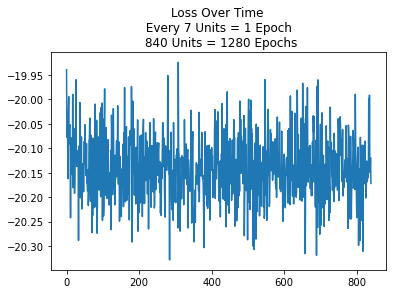

In [231]:
ls = np.array(loss_over_time)
print(np.size(ls))
plt.plot(ls[:, 1])
plt.title("Loss Over Time \n Every 7 Units = 1 Epoch \n 840 Units = 1280 Epochs")
plt.show()

1680


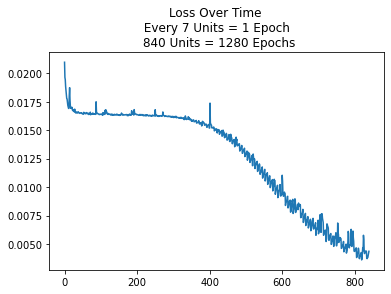

In [212]:
ls = np.array(loss_over_time)
print(np.size(ls))
plt.plot(ls[:, 0])
plt.title("Loss Over Time \n Every 7 Units = 1 Epoch \n 840 Units = 1280 Epochs")
plt.show()

##### Check Generated Dihedrals

In [205]:
pass

In [206]:
torch.cuda.empty_cache()
torch.cuda.synchronize()

In [207]:
results = model.module.sample(64, device=device)
multimodal = results[0]
means = results[1][0]
covar = results[1][1]

for index in range(0, 50, 1):
    if index % 5 == 0:
        print(index)
        
    results = model.module.sample(64, device=device)
    
    new_multimodal = results[0]
    new_means = results[1][0]
    new_covar = results[1][1]

    multimodal = torch.cat([multimodal , new_multimodal ], dim=0)
    means = torch.cat([means, new_means], dim=0)
    covar = torch.cat([covar, new_covar], dim=0)

0
5
10
15
20
25
30
35
40
45


In [213]:
#make the unimodal distribution, then sample from it.
ba_dist = dist.MultivariateNormal(means, scale_tril = covar)
ba = ba_dist.sample()
print(ba.size())

torch.Size([3264, 270])


In [214]:
#sample the multimodal stuff (yikes)
multimodal_samples = statistical_unbucketize(multimodal, GLOBAL_NUM_BINS)
multimodal_samples = torch.tensor(multimodal_samples)

#### Reconstruct the Protein Now 

In [215]:
bonds_angles = ba[:, 0:201].cpu() #[3000, 201]
unimodal = ba[:, 201:201+50].cpu() #[3000, 50]
pi = ba[:, 201+50:].cpu() #[3000, 19]

In [216]:
#process pi_angles
pi = torch.where(pi < 0, pi + torch.pi, pi)
pi = torch.where(pi < 2, pi - torch.pi, pi)

In [217]:
total_dihedrals = torch.zeros(99).repeat(3264, 1).float() #torch.arange(0, 99, 1)

total_dihedrals[:, unimodal_indx[:]] = unimodal.float()
total_dihedrals[:, pi_indx[:]] = pi.float()
total_dihedrals[:, multimodal_indx[:]] = multimodal_samples.float()

In [218]:
print(total_dihedrals.size())
print(bonds_angles.size())
whole = torch.cat([bonds_angles, total_dihedrals], dim=1)
print(whole.size())

torch.Size([3264, 99])
torch.Size([3264, 201])
torch.Size([3264, 300])


#### View IC

In [219]:
sample_loader = DataLoader(dataset_train,
                          num_workers = 4,
                          batch_size = 3000, #256 is the default batch size
                          shuffle = True)

for batch_idx, (data, _) in enumerate(sample_loader):
    data = utilities.flatten_data(data)
    np_data = np.array(data)
    break

In [220]:
unimodal_dihedrals = [1, 4, 5, 7, 8, 10, 11, 15, 16, 19, 21, 24, 25, 27, 28, 30, 31, 35, 36, 39, 41, 44, 45, 47, 48, 50, 51, 55, 56, 59, 61, 64, 65, 67, 68, 70, 71, 75, 76, 79, 81, 84, 85, 87, 88, 90, 91, 94, 97, 98]
pi_dihedrals = [0, 2, 13, 18, 20, 22, 33, 38, 40, 42, 53, 58, 60, 73, 78, 80, 82, 93, 95]
multimodal_dihedrals = [3, 6, 9, 12, 14, 17, 23, 26, 29, 32, 34, 37, 43, 46, 49, 52, 54, 57, 62, 63, 66, 69, 72, 74, 77, 83, 86, 89, 92, 96]

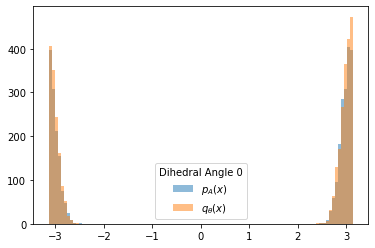

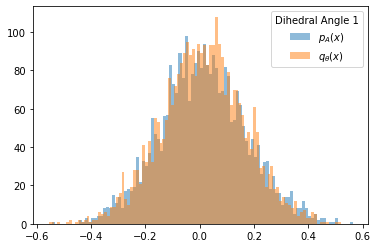

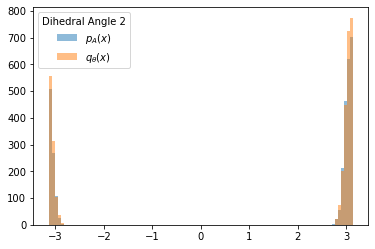

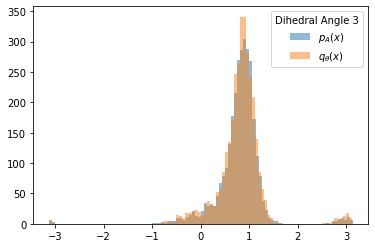

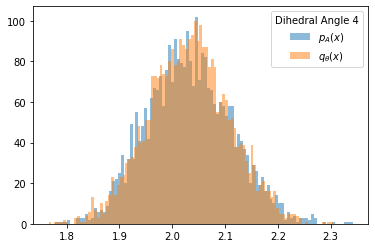

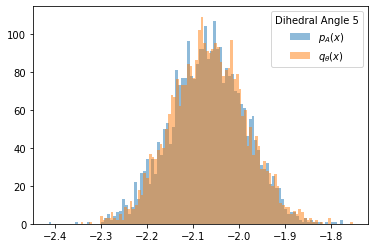

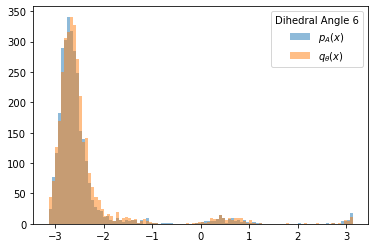

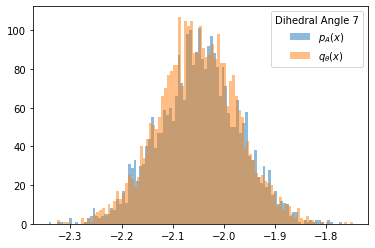

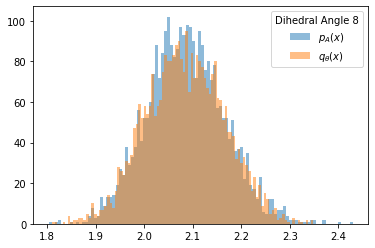

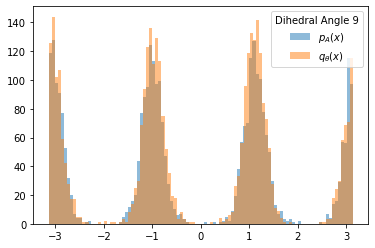

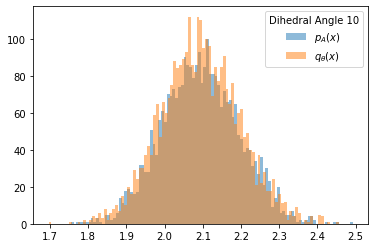

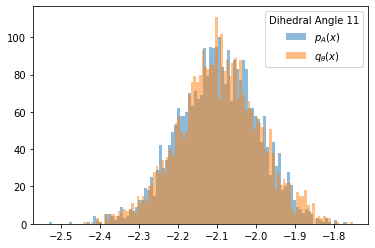

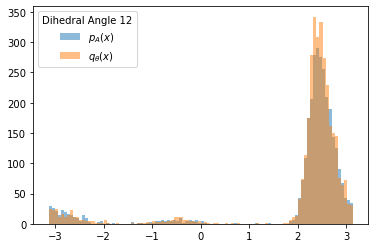

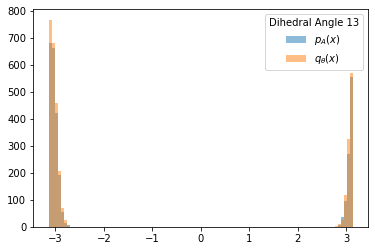

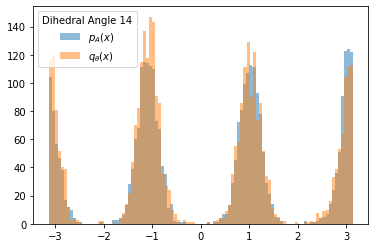

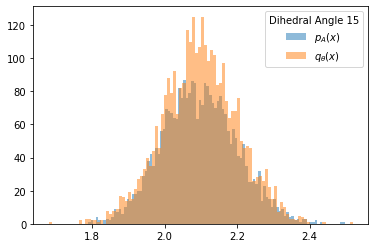

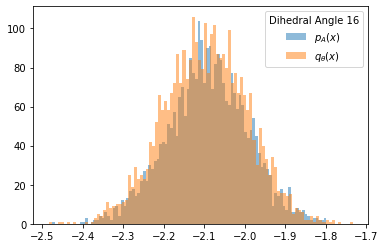

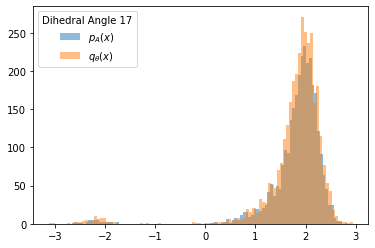

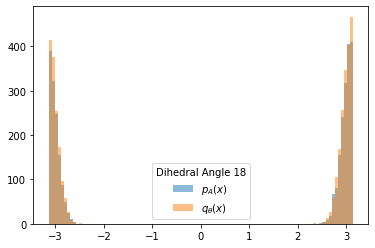

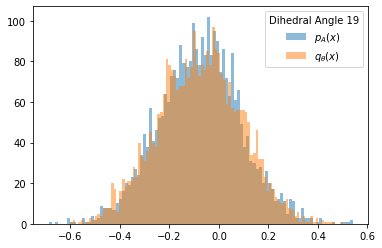

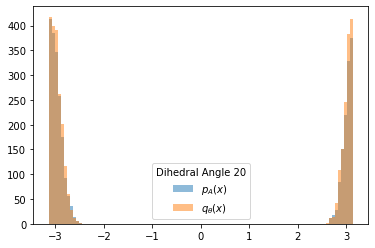

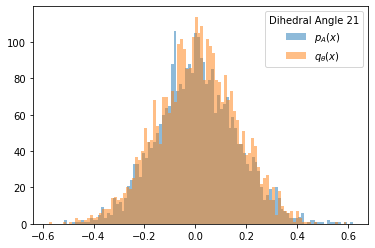

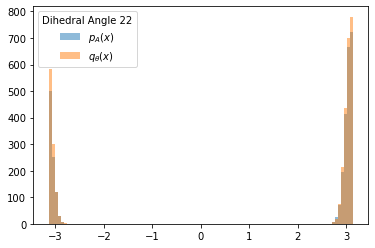

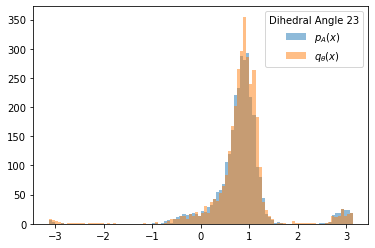

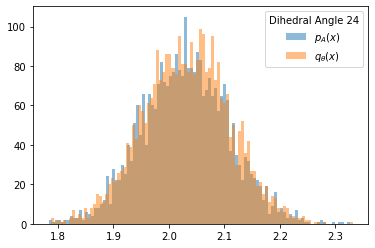

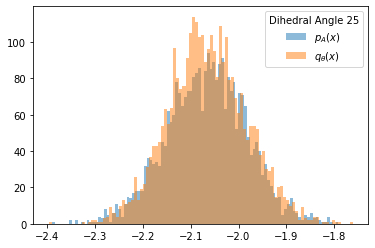

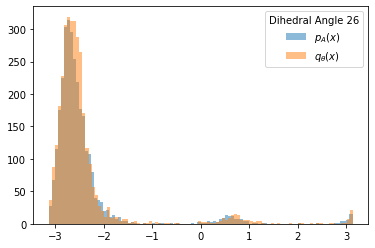

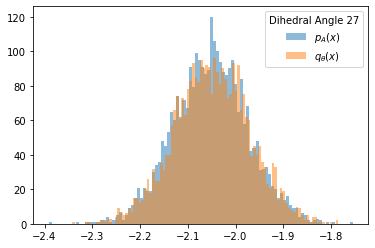

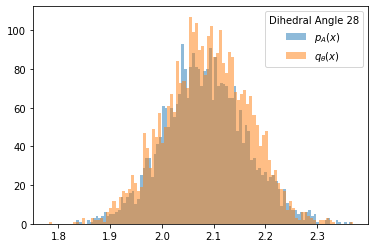

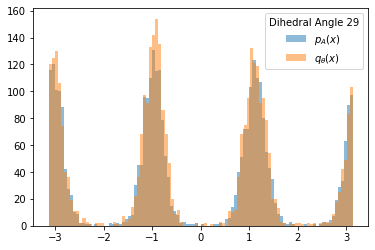

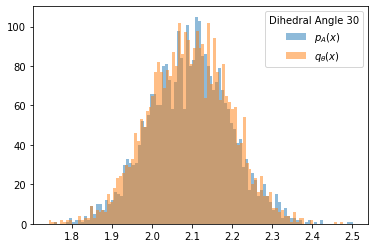

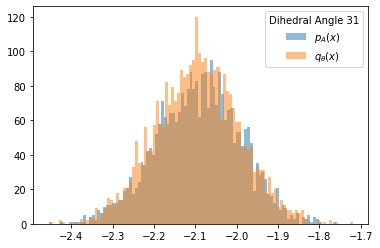

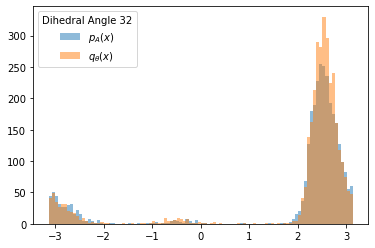

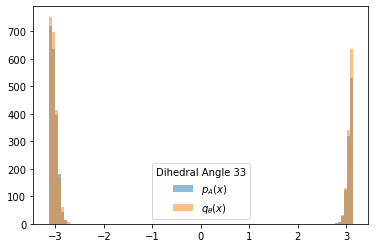

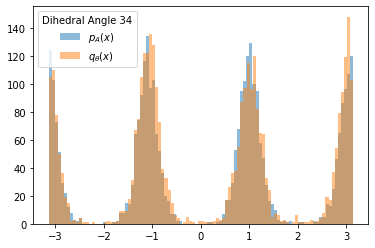

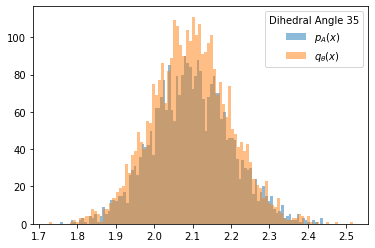

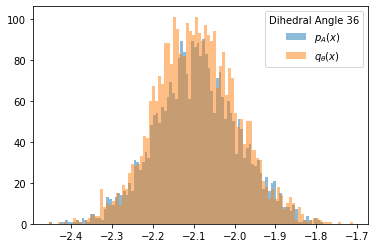

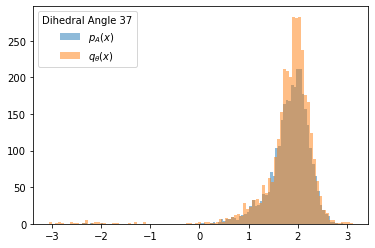

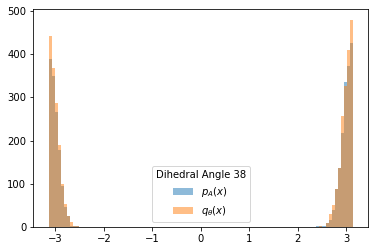

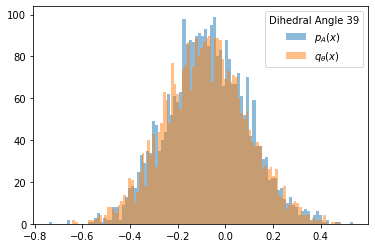

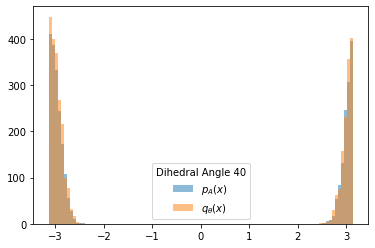

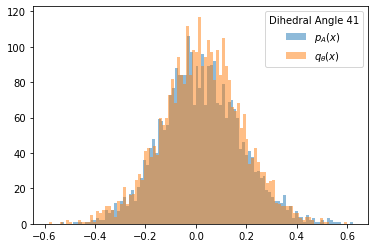

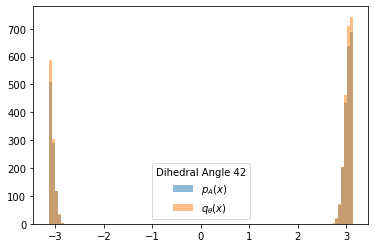

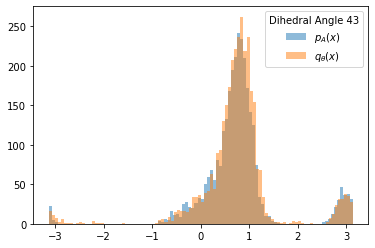

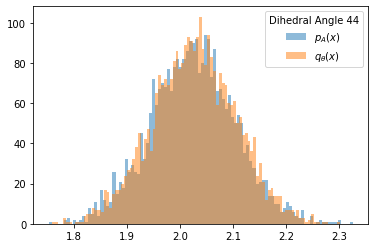

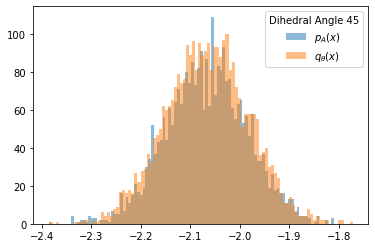

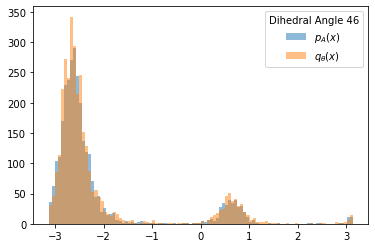

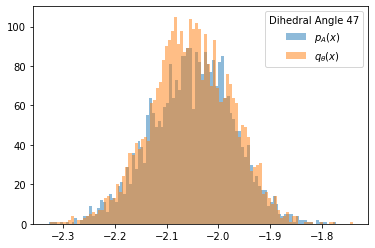

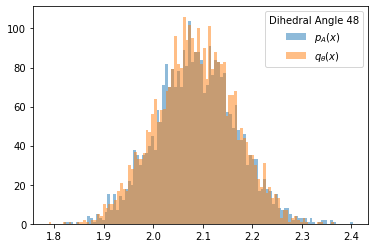

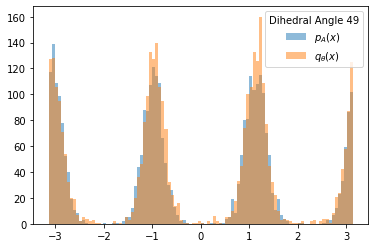

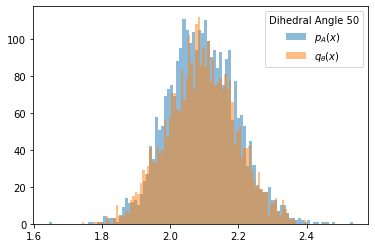

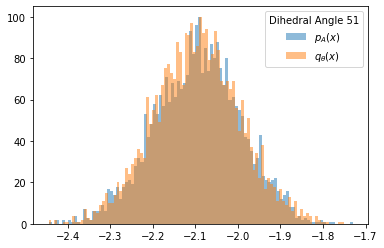

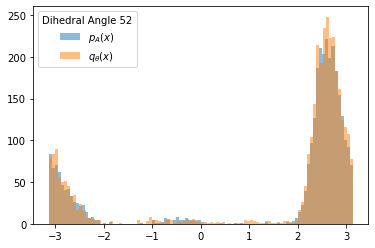

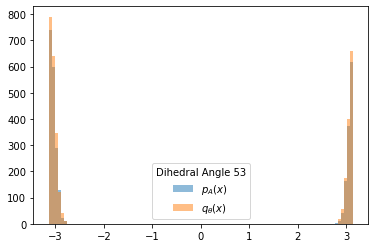

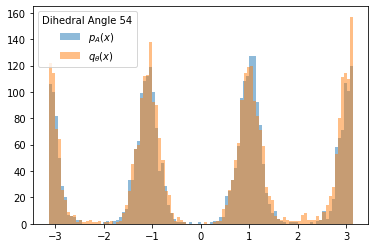

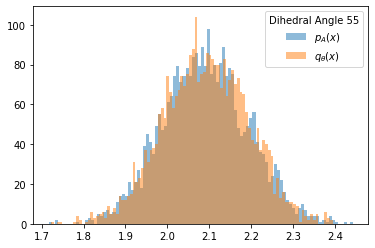

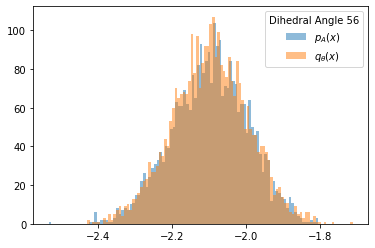

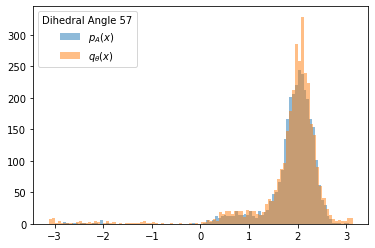

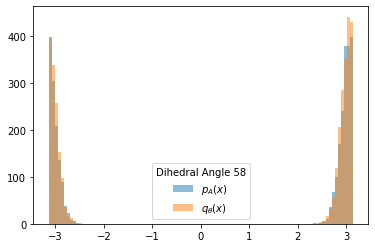

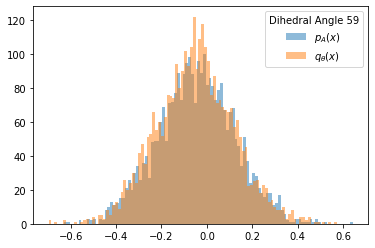

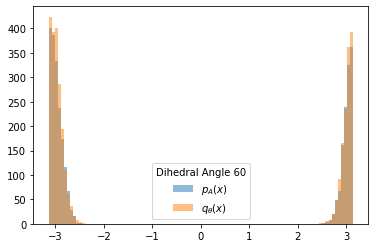

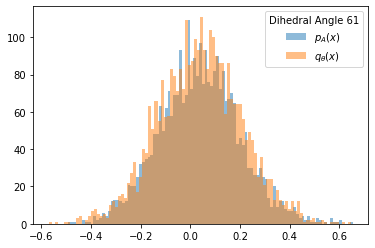

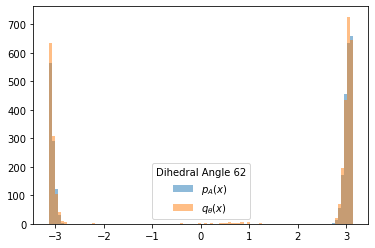

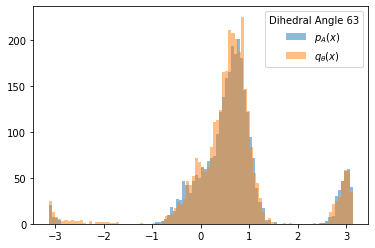

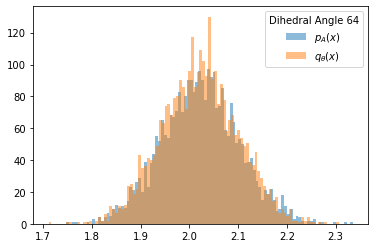

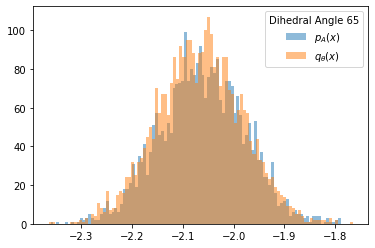

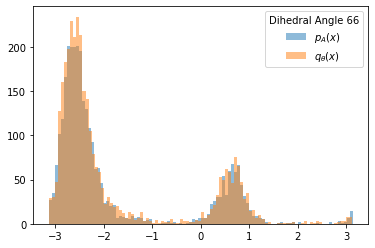

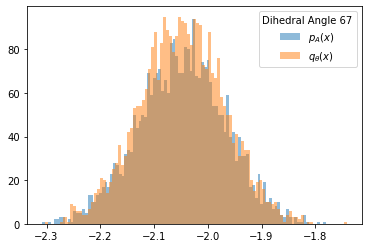

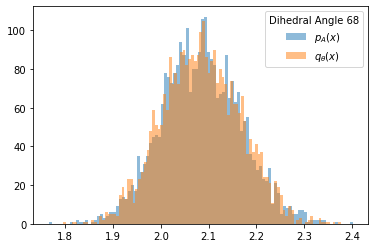

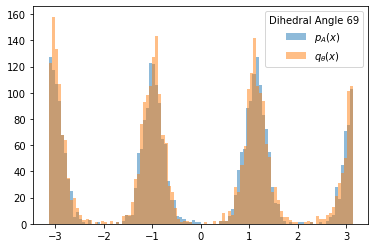

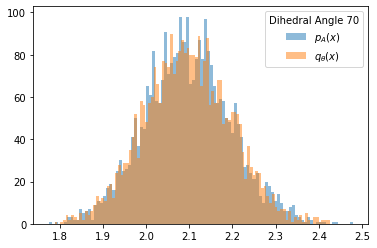

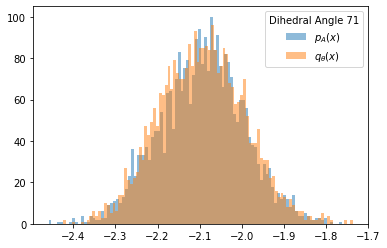

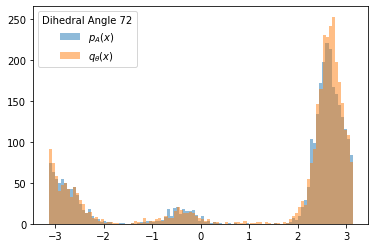

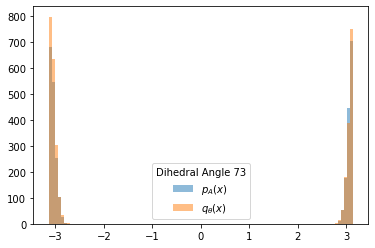

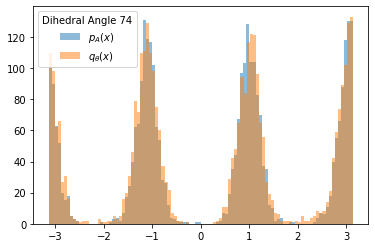

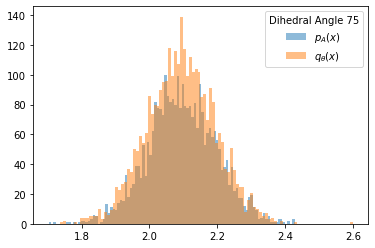

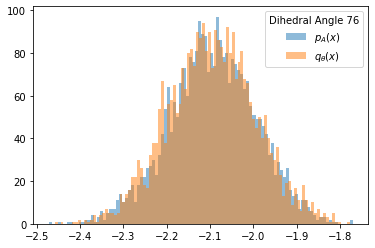

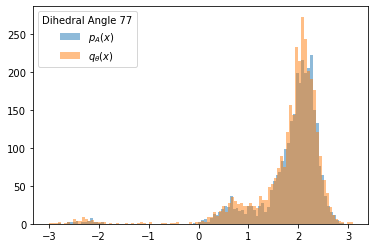

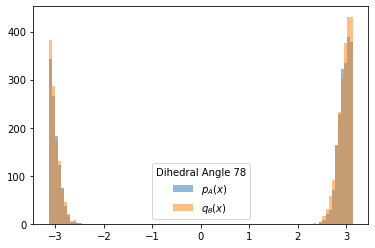

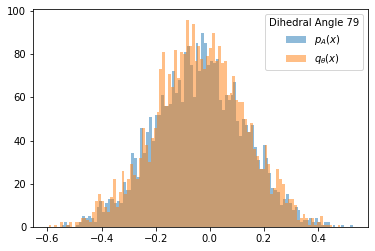

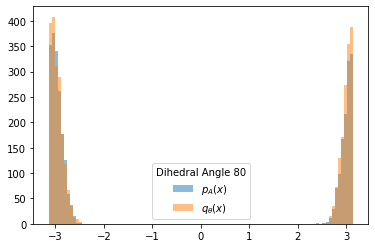

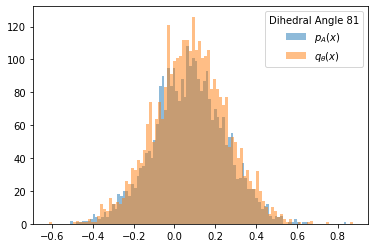

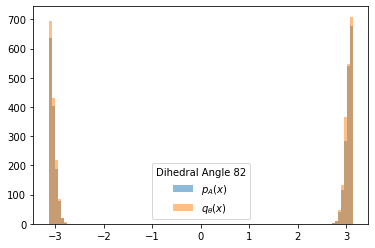

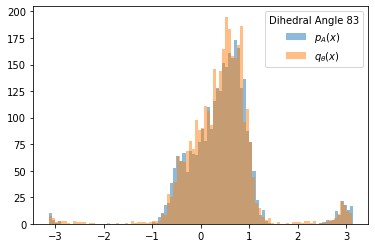

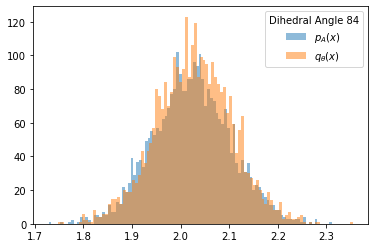

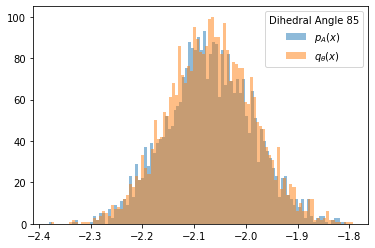

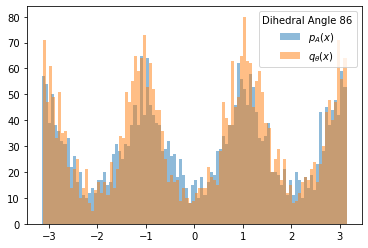

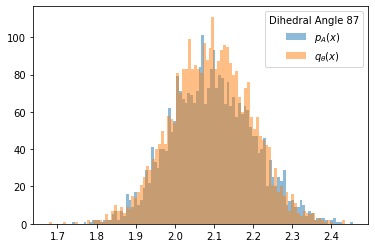

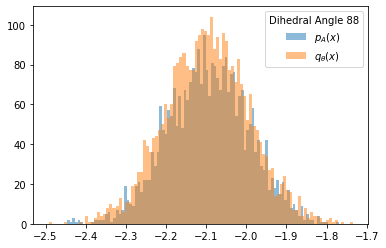

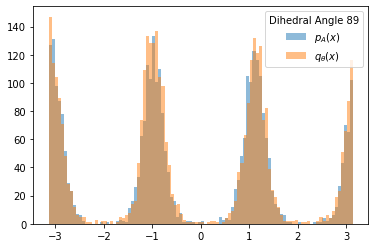

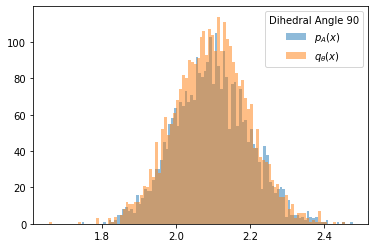

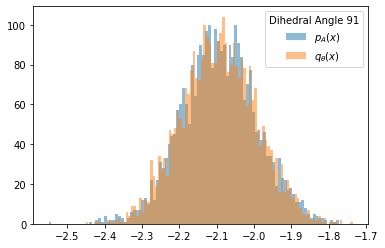

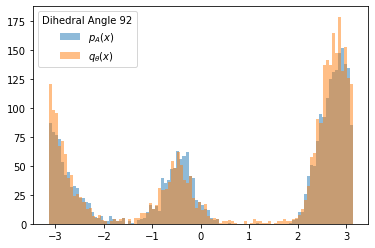

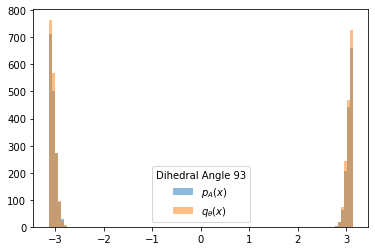

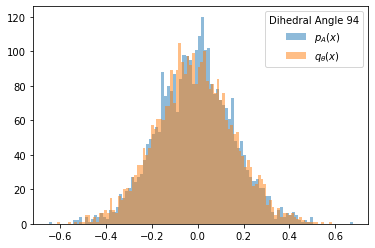

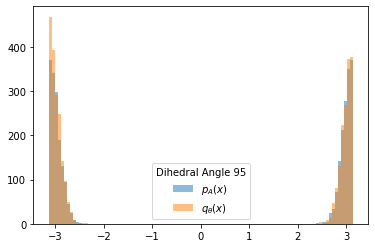

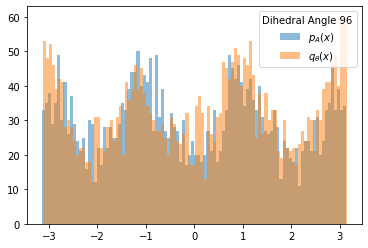

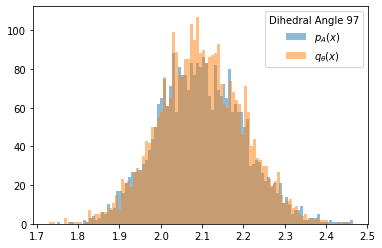

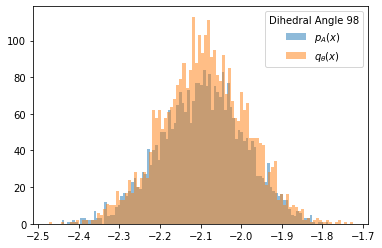

In [221]:
for index in range(0, 99, 1):
    if True:
        indx = str(index)
        plt.hist(np_data[:, index+201], label = "$p_A(x)$ ", bins = 100, alpha = 0.5)
        plt.hist(whole[:, index+201], label = "$q_\\theta(x)$ ", bins = 100, alpha = 0.5)
    
        plt.legend(title = "Dihedral Angle " + indx)
        plt.show()

In [ ]:
'''
for index in range(0, 99, 1):
    if index in pi_dihedrals:
        indx = str(index)
        plt.hist(np_data[:, index+201], label = "$p_A(x)$ ", bins = 100, alpha = 0.5)
        #plt.hist(np_samples[:, index], label = "$q_\\theta(x)$ ", bins = 100, alpha = 0.5)
    
        plt.legend(title = "Dihedral Angle " + indx)
        plt.show()
'''

In [ ]:
'''
for index in range(0, 99, 1):
    if index not in (unimodal_dihedrals + pi_dihedrals):
        indx = str(index)
        plt.hist(np_data[:, index+201], label = "$p_A(x)$ ", bins = 100, alpha = 0.5)
        #plt.hist(np_samples[:, index], label = "$q_\\theta(x)$ ", bins = 100, alpha = 0.5)
    
        plt.legend(title = "Dihedral Angle " + indx)
        plt.show()
'''

In [ ]:
'''
for index in unimodal_dihedrals:
    indx = str(index)

    plt.hist(np_data[:, index+201], label = "$p_A(x)$ ", bins = 100, alpha = 0.5)
    #plt.hist(np_samples[:, index], label = "$q_\\theta(x)$ ", bins = 100, alpha = 0.5)
    
    plt.legend(title = "Dihedral Angle " + indx)
    plt.show()
'''

#### View Dihedrals

In [222]:
whole = whole.cpu().numpy()

In [ ]:
for index in range(0, 99, 1):
    indx = str(index)

    plt.hist(np_data[:, index+201], label = "$p_A(x)$ ", bins = 100, alpha = 0.5)
    plt.hist(whole[:, index+201], label = "$q_\\theta(x)$ ", bins = 100, alpha = 0.5)
    
    plt.legend(title = "Dihedral Angle " + indx)
    plt.show()

### Calculate Energies

In [223]:
molecules = utilities.rebuild(torch.tensor(whole))
potential_energy_q_theta = dataset_train.compute_potential_energy_for_ic(molecules)

In [224]:
potential_energy_md = np.concatenate(
    [dataset_train.potential_energy_kJ_per_mole,
     dataset_test.potential_energy_kJ_per_mole]
)

In [225]:
dataset_test = MMCDataset(root = './data',
                           molecule_name = name,
                           train = False,
                           coordinate_type = 'internal')

In [226]:
p_x = np.concatenate(
    [dataset_train.potential_energy_kJ_per_mole,
     dataset_test.potential_energy_kJ_per_mole]
)

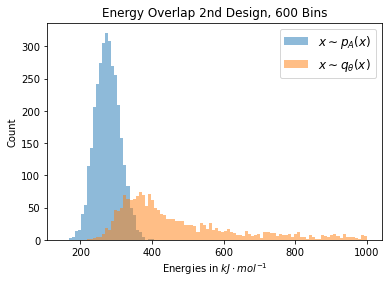

In [233]:
plt.hist(potential_energy_md[:3264], range =(150, 1000), bins = 100, alpha = 0.5, label = "$x \sim p_A(x)$")
plt.hist(potential_energy_q_theta, range =(150, 1000), bins = 100, alpha = 0.5, label = "$x \sim q_{\\theta}(x)$")
plt.title("Energy Overlap 2nd Design, 600 Bins")
plt.legend(prop={'size': 12})
plt.xlabel('Energies in $kJ \cdot mol^{-1}$')
plt.ylabel('Count')
plt.show()

$p$(multimodal dihedrals) $\cdot$ $p$(unimodal dihedrals, angles, bonds | multimodal dihedrals) 

In [230]:
torch.save(model.state_dict(), "transformer_collective_variable_dict.pth")
torch.save(model, "transformer_collective_variable.pth")

$p$(dihedrals, angles | bond) $\cdot p$(bond)